In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal

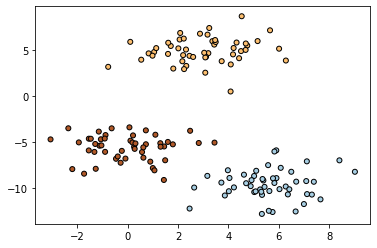

In [2]:
n_clusters = 3

X, Y = X, y = make_blobs(n_samples=[50 for _ in range(n_clusters)], n_features=2,
                  random_state=10, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
            s=25, edgecolor='k', cmap=plt.cm.Paired)

In [3]:
def r_k(x, mean, cov, pi, k):
    
    a = pi[k] * multivariate_normal(mean[k], cov[k]).pdf(x)
    b = np.sum([pi[p] * multivariate_normal(mean[p], cov[p]).pdf(x) for p in range(pi.shape[0])])
    
    if b == 0:
        pass
    
    return a/b

def EM(X, K, mean_0, cov_0, pi_0, alphas, k_0, v_0, iter=10, debug=False):
    N, D = X.shape
    mean_prev = mean_0.copy()
    cov_prev = cov_0.copy()
    pi_prev = pi_0.copy()
    
    mean = mean_0.copy()
    cov = cov_0.copy()
    pi = pi_0.copy()
    
    for i in range(iter):
        if debug:
            print(f"Iteração {i} #############")
        for k in range(K): # para cada valor latente
#             responsabilities = np.array([r_k(x_i, mean_prev, cov_prev, pi_prev, k) for x_i in X])
            responsabilities = r_k(X, mean_prev, cov_prev, pi_prev, k)
            sum_res = np.sum(responsabilities, axis=0) 
            # valor atualizado da probabilidade categórica de k
            pi[k] = (alphas[k] - 1 + sum_res) / (N - K + np.sum(alphas))
            
            # x_i ponderado pela responsabilidade
            x_k = responsabilities.dot(X) / sum_res
            mean[k,:] = (k_0 * mean_0[k,:] + x_k * sum_res) / (k_0 + sum_res)

            distances = responsabilities.dot(X - x_k)
            cov_k = (cov_0[k,:,:] + distances.T.dot(distances) + (k_0*sum_res / (k_0 + sum_res)) * np.outer(x_k - mean_0[k,:], x_k - mean_0[k,:]))
            cov_k = cov_k / (v_0 + D + 2 + sum_res)
            cov[k,:,:] =  cov_k
            
            if debug:
                print(f"Variavel latente {k}:")
                print(f"média: {mean[k]}")
                print(f"covariância:\n{cov[k]}\n\n")
                print(f"pi: {pi[k]}")
                print("-------------------------\n")
        
        mean_prev = mean.copy()
        cov_prev = cov.copy()
        pi_prev = pi.copy()

    return mean, cov, pi

In [4]:
def generate_initial_values(X, K, dim):
    mean_0 = X[np.random.choice(np.arange(X.shape[0]), K)]
    cov_0 = np.array([np.diag(np.var(X,axis=0)) for _ in range(K)])
    
    return mean_0, cov_0

K = n_clusters
mean_0, cov_0 = generate_initial_values(X, K=K, dim=X.shape[1])
pi_0 = np.array([1/K for _ in range(K)])
alphas = np.array([2 for _ in range(K)])

print(f"Médias iniciais:\n{mean_0}")

mean, cov, pi = EM(X, K, mean_0, cov_0, pi_0, alphas, 0, 4, iter=50, debug=False)

print("\n##########################\n")
print("Resultados finais: ")
for k in range(K):
    print(f"Variavel latente {k}:")
    print(f"média: {mean[k]}")
    print(f"covariância:\n{cov[k]}\n")
    print(f"pi: {pi[k]}")
    print("-------------------------\n")

Médias iniciais:
[[-0.3897942  -6.54665206]
 [ 4.9177025  -9.11670611]
 [ 1.81329466  2.99540633]]

##########################

Resultados finais: 
Variavel latente 0:
média: [-0.04222948 -5.5167298 ]
covariância:
[[8.68536995e-01 8.88814250e-32]
 [8.88814250e-32 4.76580863e+00]]

pi: 0.008706406860849688
-------------------------

Variavel latente 1:
média: [ 5.49705163 -9.60201192]
covariância:
[[8.65585703e-01 1.90986140e-30]
 [1.90986140e-30 4.74961440e+00]]

pi: 0.008892086410050471
-------------------------

Variavel latente 2:
média: [2.79651047 4.96369159]
covariância:
[[8.71114109e-01 2.19343880e-32]
 [2.19343880e-32 4.77994969e+00]]

pi: 0.00854529757877304
-------------------------



In [5]:
def get_prob(X, mean, cov, pi, with_k=False):
    K = mean.shape[0]
    responsabilities = np.array([r_k(X, mean, cov, pi, k) for k in range(K)])
    ks = np.argmax(responsabilities, axis=0)
    probs = np.array([multivariate_normal(mean[k], cov[k]).pdf(x) for x,k in zip(X, ks)])
    
    if with_k:
        return probs, ks
    else:
        return probs

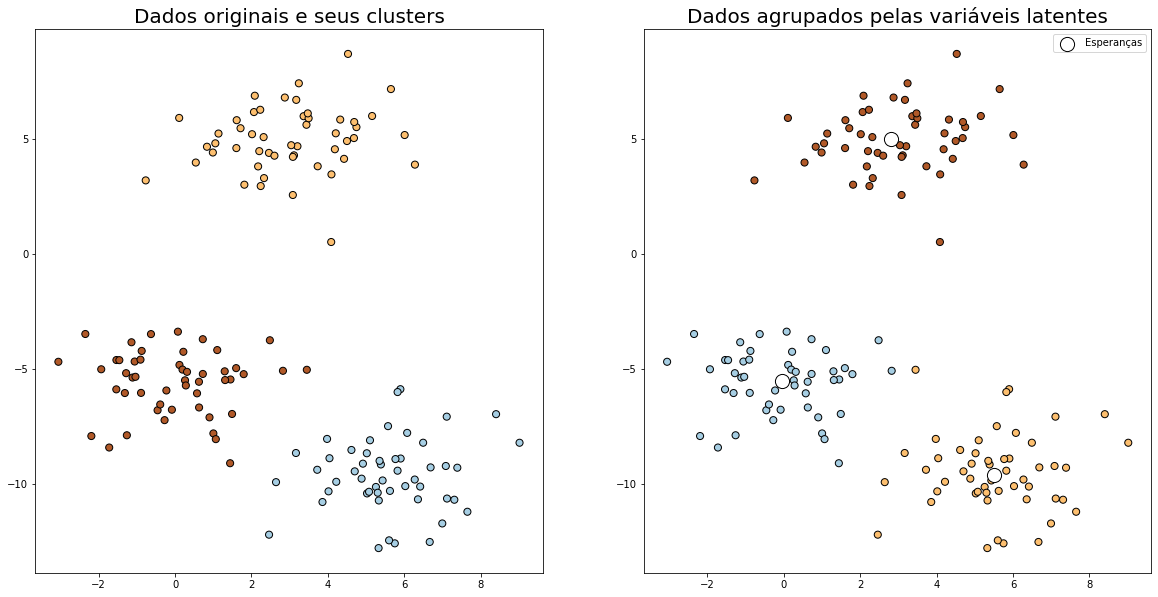

In [6]:
z = get_prob(X, mean, cov, pi, with_k=True)[1]

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
            s=50, edgecolor='k', cmap=plt.cm.Paired)
plt.title("Dados originais e seus clusters", fontsize=20)

plt.subplot(1,2,2)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=z,
            s=50, edgecolor='k', cmap=plt.cm.Paired)
plt.scatter(mean[:,0], mean[:,1], marker="o", c="w", s=200, edgecolors='k', label="Esperanças")
plt.legend()
_ = plt.title("Dados agrupados pelas variáveis latentes", fontsize=20)

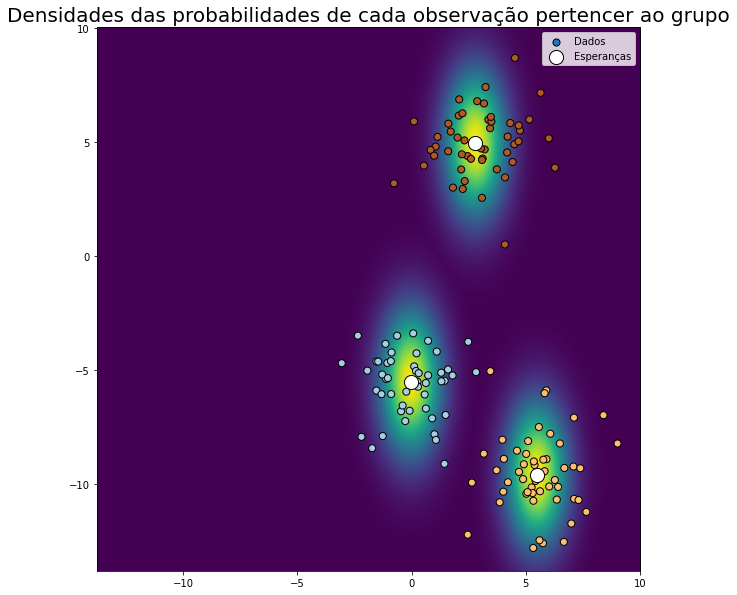

In [7]:
resolution = 200
margin = 1
x = y = np.linspace(X.min()-margin,X.max()+margin,resolution)
grid = np.dstack(np.meshgrid(x,y)).reshape(-1,2)

densities = get_prob(grid, mean, cov, pi).reshape(resolution, resolution)

plt.figure(figsize=(10,10))
plt.imshow(densities, origin='lower', extent=(x[0],x[-1],y[0],y[-1]))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=z,
            s=50, edgecolor='k', cmap=plt.cm.Paired, label="Dados")
plt.scatter(mean[:,0], mean[:,1], marker="o", c="w", s=200, edgecolors='k', label="Esperanças")
plt.title("Densidades das probabilidades de cada observação pertencer ao grupo", fontsize=20)
plt.legend()

### Comparando com a implementação do [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture)

In [8]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=K, random_state=42).fit(X)
gm

GaussianMixture(n_components=3, random_state=42)

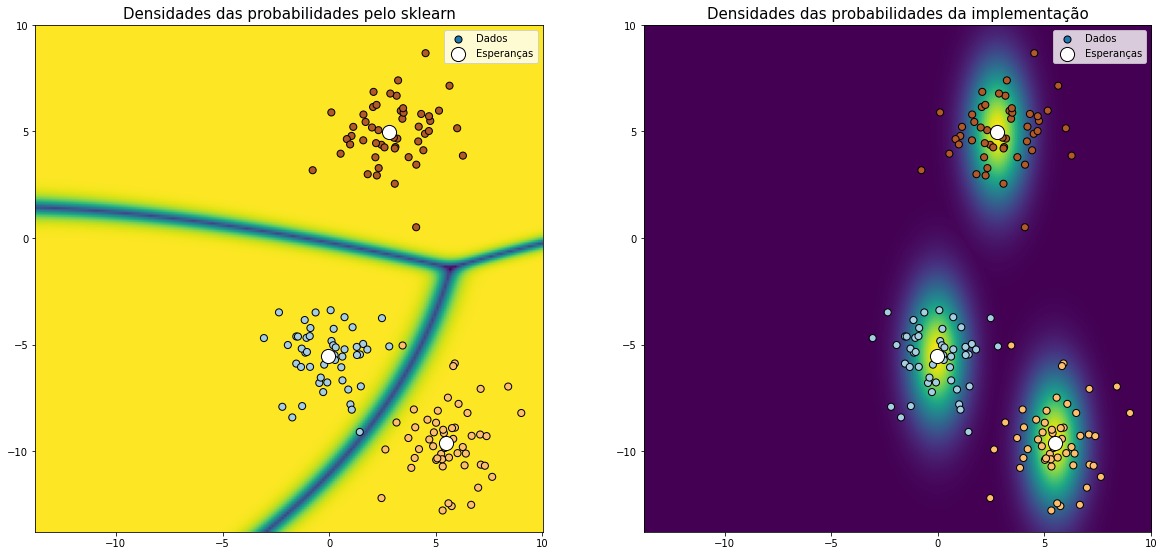

In [10]:
resolution = 200
margin = 1

densities_sklearn = gm.predict_proba(grid).max(axis=1).reshape(resolution, resolution)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(densities_sklearn, origin='lower', extent=(x[0],x[-1],y[0],y[-1]))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=z,
            s=50, edgecolor='k', cmap=plt.cm.Paired, label="Dados")
plt.scatter(mean[:,0], mean[:,1], marker="o", c="w", s=200, edgecolors='k', label="Esperanças")
plt.title("Densidades das probabilidades pelo sklearn", fontsize=15)
plt.legend()

plt.subplot(1,2,2)
plt.imshow(densities, origin='lower', extent=(x[0],x[-1],y[0],y[-1]))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=z,
            s=50, edgecolor='k', cmap=plt.cm.Paired, label="Dados")
plt.scatter(mean[:,0], mean[:,1], marker="o", c="w", s=200, edgecolors='k', label="Esperanças")
plt.title("Densidades das probabilidades da implementação", fontsize=15)
plt.legend()